# Define peak positions


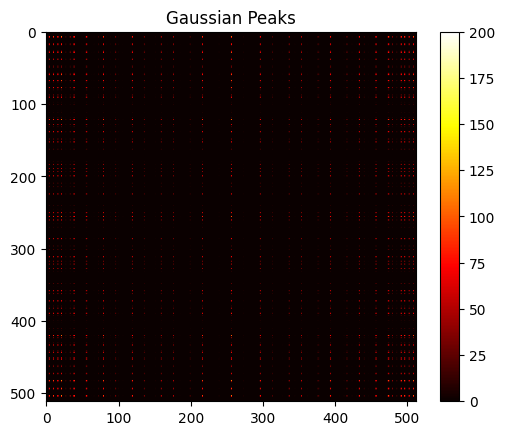

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, total_intensity):
    """Gaussian peak simulation."""
    return total_intensity * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

def generate_gaussian_peak_array(size, sigma_x, sigma_y, freq_x, freq_y, shift_x, shift_y, total_intensity):
    array = np.zeros((size, size))
    x = np.linspace(0, size - 1, size)
    y = np.linspace(0, size - 1, size)
    x_grid, y_grid = np.meshgrid(x, y)

    x0 = (size / 2) * (1 + np.sin(2 * np.pi * freq_x * (x_grid+ shift_x) / size)) 
    y0 = (size / 2) * (1 + np.sin(2 * np.pi * freq_y * (y_grid+ shift_y) / size)) 
    for i in range(size):
        for j in range(size):
            array[i, j] = gaussian_2d(x_grid[i, j], y_grid[i, j], x0[i, j], y0[i, j], sigma_x, sigma_y, total_intensity)
    
    return array

size = 512
sigma_x = 14
sigma_y = 20
freq_x = 90
freq_y = 50
shift_x = 0 
shift_y = 0 
total_intensity = 200  


peak_positions = generate_gaussian_peak_array(size, sigma_x, sigma_y, freq_x, freq_y, shift_x, shift_y, total_intensity)

plt.imshow(peak_positions, cmap='hot')
plt.colorbar()
plt.title('Gaussian Peaks')
plt.show()


# Define scan positions

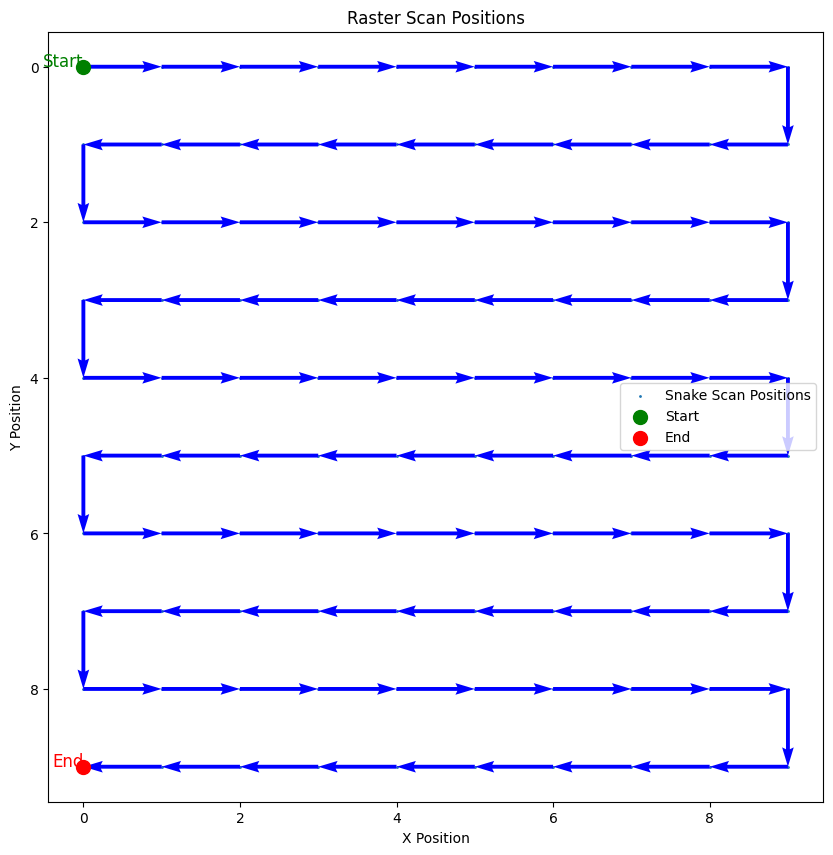

In [48]:


def generate_raster_scan_positions(size):
    x_positions = []
    y_positions = []
    
    for i in range(size):
        if i % 2 == 0:  # Even rows
            for j in range(size):
                x_positions.append(j)
                y_positions.append(i)
        else:  # Odd rows
            for j in range(size-1, -1, -1):  # Reverse iteration for odd rows
                x_positions.append(j)
                y_positions.append(i)
    
    return np.array(x_positions), np.array(y_positions)

size = 10
x_positions, y_positions = generate_raster_scan_positions(size)


def plot_scan_positions(x_positions, y_positions, title='Scan Positions', scan_type='Snake'):
    u = np.diff(x_positions)
    v = np.diff(y_positions)

    u = np.append(u, 0)
    v = np.append(v, 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_positions, y_positions, s=1, label=f'{scan_type} Scan Positions')

    plt.quiver(x_positions, y_positions, u, v, angles='xy', scale_units='xy', scale=1, color='blue', width=0.005, headwidth=3, headlength=5)

    plt.scatter(x_positions[0], y_positions[0], color='green', s=100, label='Start')
    plt.annotate('Start', (x_positions[0], y_positions[0]), color='green', fontsize=12, ha='right')

    plt.scatter(x_positions[-1], y_positions[-1], color='red', s=100, label='End')
    plt.annotate('End', (x_positions[-1], y_positions[-1]), color='red', fontsize=12, ha='right')

    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.gca().invert_yaxis()  
    plt.show()
    
plot_scan_positions(x_positions, y_positions, title='Raster Scan Positions', scan_type='Snake')

# Generate data and scan positions
- We want raster scan on 512 x 512 grid (but we will do every other scan positions)
- Peak positions in data will vary sinusoidally 

In [66]:
size = 512
x_positions, y_positions = generate_raster_scan_positions(size)
x_positions, y_positions = x_positions[::5000], y_positions[::5000]
print('finished')
data = np.array([generate_gaussian_peak_array(size, sigma_x, sigma_y, freq_x, freq_y, shift_x, shift_y, total_intensity) for shift_x, shift_y in zip(x_positions, y_positions)]) #list compression to genreate at all pos


finished


In [67]:
data.shape, x_positions.shape, y_positions.shape

((53, 512, 512), (53,), (53,))

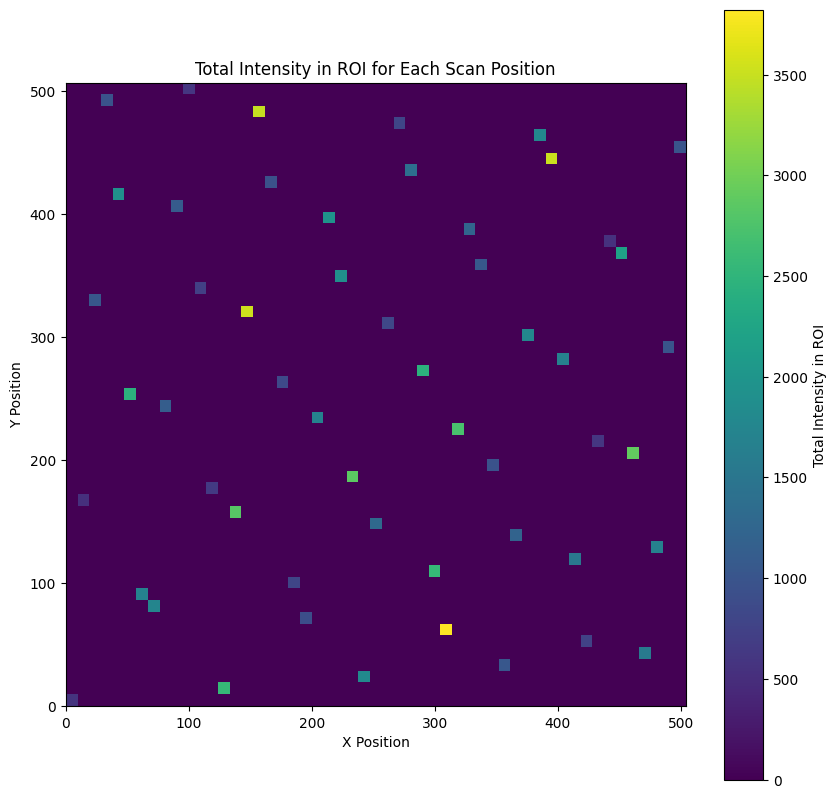

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


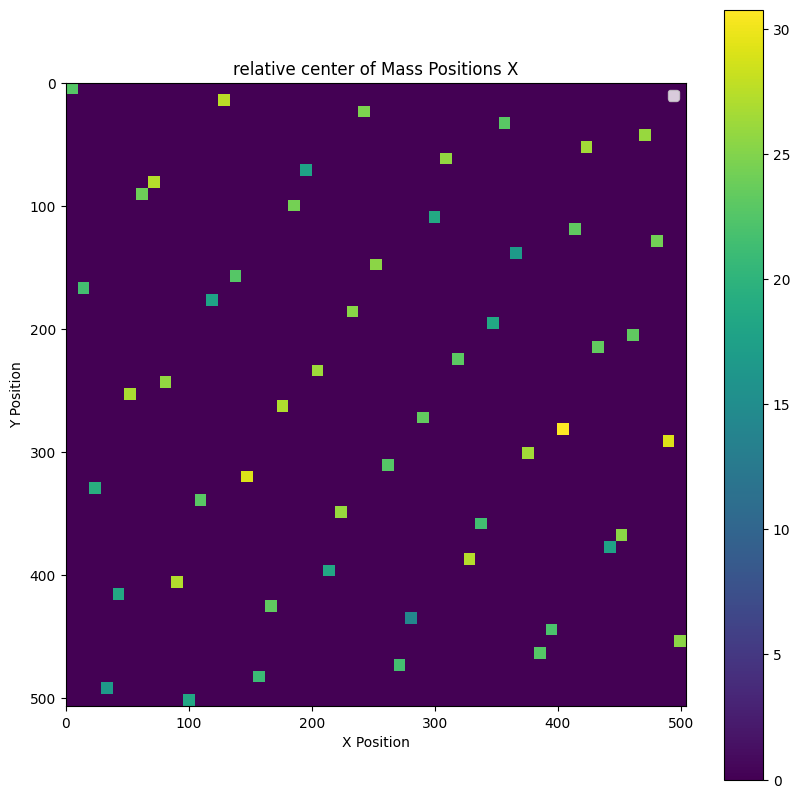

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


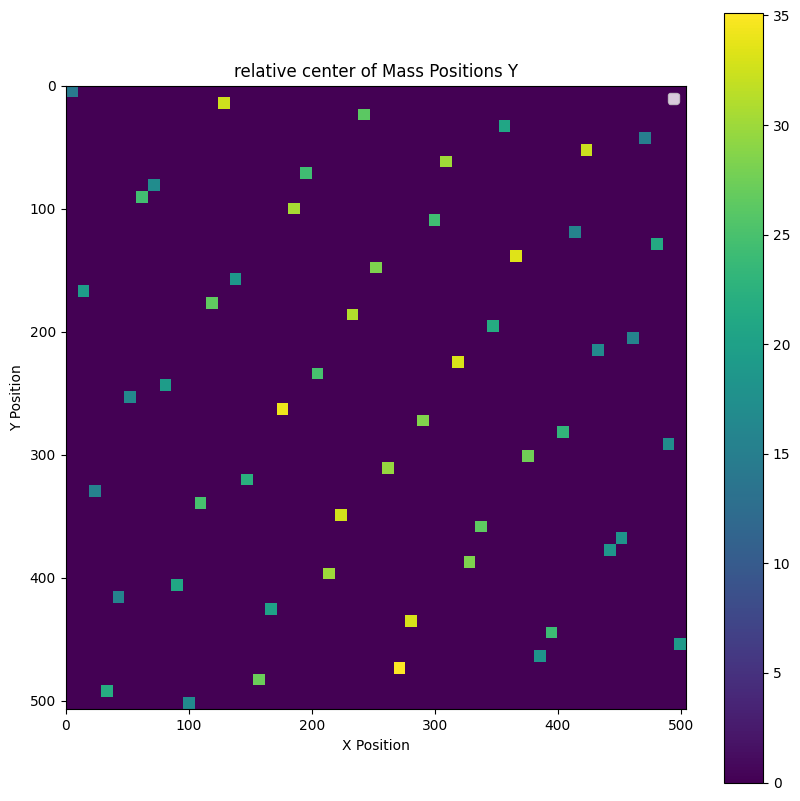

In [80]:
from scipy.ndimage import center_of_mass

roi_x = 100
roi_y = 200
roi_width = 50
roi_height = 50

intensity_values = []
com_global_x_ls = []
com_global_y_ls = []

for frame in data:
    roi = frame[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
    total_intensity_in_roi = np.sum(roi)
    intensity_values.append(total_intensity_in_roi)

    com_y, com_x = center_of_mass(roi)
    com_global_x = com_x #roi_x + com_x
    com_global_y = com_y #roi_y + com_y
    com_global_x_ls.append(com_global_x)
    com_global_y_ls.append(com_global_y)

unique_x_positions = np.unique(x_positions)
unique_y_positions = np.unique(y_positions)
intensity_matrix = np.zeros((len(unique_y_positions), len(unique_x_positions)))
com_x_matrix = np.zeros((len(unique_y_positions), len(unique_x_positions)))
com_y_matrix = np.zeros((len(unique_y_positions), len(unique_x_positions)))

for i, (x, y, intensity) in enumerate(zip(x_positions, y_positions, intensity_values)):
    x_idx = np.where(unique_x_positions == x)[0][0]
    y_idx = np.where(unique_y_positions == y)[0][0]
    intensity_matrix[y_idx, x_idx] = intensity
    
for i, (x, y, intensity) in enumerate(zip(x_positions, y_positions, com_global_x_ls)):
    x_idx = np.where(unique_x_positions == x)[0][0]
    y_idx = np.where(unique_y_positions == y)[0][0]
    com_x_matrix[y_idx, x_idx] = intensity
    
for i, (x, y, intensity) in enumerate(zip(x_positions, y_positions, com_global_y_ls)):
    x_idx = np.where(unique_x_positions == x)[0][0]
    y_idx = np.where(unique_y_positions == y)[0][0]
    com_y_matrix[y_idx, x_idx] = intensity

plt.figure(figsize=(10, 10))
plt.imshow(intensity_matrix, cmap='viridis', extent=(min(x_positions), max(x_positions), min(y_positions), max(y_positions)), origin='lower')
plt.colorbar(label='Total Intensity in ROI')
plt.title('Total Intensity in ROI for Each Scan Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

# com_x_positions, com_y_positions = zip(*com_positions)

plt.figure(figsize=(10, 10))
plt.imshow(com_x_matrix,  cmap='viridis', extent=(min(x_positions), max(x_positions), min(y_positions), max(y_positions)), origin='lower')
plt.colorbar()
plt.title('relative center of Mass Positions X')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(com_y_matrix,  cmap='viridis', extent=(min(x_positions), max(x_positions), min(y_positions), max(y_positions)), origin='lower')
plt.colorbar()
plt.title('relative center of Mass Positions Y')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.gca().invert_yaxis()
plt.show()